# Auswertung der ersten Messungen

In [17]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

d = {
}

expected_results_input = "./../expectedResults.json"

folder = "./../testresults/*.json"

file_list = glob.glob(folder)

data_array = []

with open (expected_results_input) as f:
    expected_results = json.load(f)
    print(expected_results)

{'name': 'Erwartetete Testergebnisse der Testsuite', 'desprcition': '10 QPS, 120 Sekunden, 1200 Request, Transienete Störungen für  40s', 'testcases': [{'name': 'normal', 'description': 'Noramles Verhalten - Positivtestfall', 'response-count': {'min': 1200, 'max': 1200}, 'RetCodes': {'200': {'min': 1200, 'max': 1200}, '500': {'min': 0, 'max': 0}, '503': {'min': 0, 'max': 0}, 'Other': {'min': 0, 'max': 0}}, 'Percentiles': {'50': {'min': 0, 'max': 0.1}, '90': {'min': 0, 'max': 0.2}}}, {'name': 'perm-error', 'description': 'Permanente Fehler', 'response-count': {'min': 1200, 'max': 1200}, 'RetCodes': {'200': {'min': 0, 'max': 0}, '500': {'min': 0, 'max': 100, '__comment': '10 Sekunden (100 Anfragen) Erkennungszeit wird geduldet'}, '503': {'min': 1000, 'max': 1200}, 'Other': {'min': 0, 'max': 0}}, 'Percentiles': {'50': {'min': 0, 'max': 0.1}, '90': {'min': 0, 'max': 0.2}}}]}


In [18]:
    
for file in file_list:
    with open(file) as f:
      json_data = json.load(f)
    row_dataframe = pd.json_normalize(json_data)
    percentiles_dataframe = pd.json_normalize(json_data['DurationHistogram']['Percentiles'])
    
    if "ErrorsDurationHistogram" in json_data:
        if json_data["ErrorsDurationHistogram"]["Count"] != 0:
            errors_percentiles_dataframe = pd.json_normalize(json_data['ErrorsDurationHistogram']['Percentiles'])
            row_dataframe['Errors50Percentile'] = errors_percentiles_dataframe[errors_percentiles_dataframe["Percentile"] == 50.0]['Value'] 
     #       row_dataframe['Erros90Percentile'] = errors_percentiles_dataframe[errors_percentiles_dataframe["Percentile"] > 90.0]['Value']

    #row_dataframe['99Percentile'] = percentiles_dataframe[percentiles_dataframe["Percentile"] == 99.9]['Value']
    row_dataframe['50Percentile'] = percentiles_dataframe[percentiles_dataframe["Percentile"] == 50.0]['Value']
    
    data_array.append(row_dataframe)

data = pd.concat(data_array, ignore_index=True)


#row_dataframe["TotalResponses"] = row_dataframe.filter(regex="RetCodes.*").sum(axis=1)
#Ausgabe der RetCodes der Istio-Testreihe
#data[data['Labels'].str.contains("-i-")].filter(regex="Label|RetCodes.*|50Percentile")

#Ausgabe der RetCodes der Traefik-Testreihe
overload_df = data[data['Labels'].str.contains("trans-overload-t-")]
overload_df = overload_df.fillna(0.0)
overload_df['Labels'] = overload_df['Labels'].replace({'trans-overload-t-':'','with-config-traefik-cb':'traefik','with-r4j-cb':'r4j','without-cb':'none','with-default-traefik':'df-traefik'},regex=True)
overload_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.-1,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.500


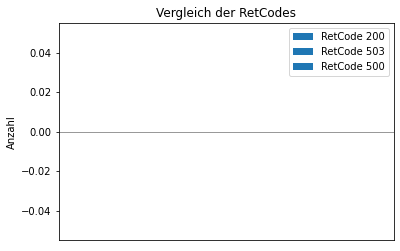

In [19]:
N = overload_df.shape[0]

ind = np.arange(N)*10   # the x locations for the groups
width = 5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()


p1 = ax.bar(ind, list(overload_df['RetCodes.200']), width, label='RetCode 200')
p2 = ax.bar(ind, list(overload_df['RetCodes.503']), width, list(overload_df['RetCodes.200']), label='RetCode 503')
p3 = ax.bar(ind, list(overload_df['RetCodes.500']), width, list(overload_df['RetCodes.503']), label='RetCode 500')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Anzahl')
ax.set_title('Vergleich der RetCodes')
ax.set_xticks(ind, labels=list(overload_df['Labels']))
ax.legend()

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p3, label_type='center')

plt.show()

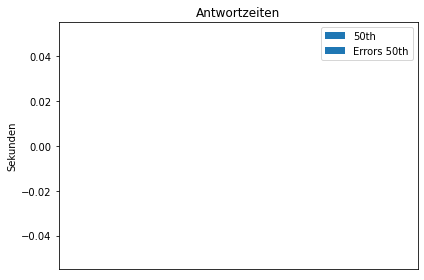

In [20]:

#see: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
labels = overload_df['Labels']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list(overload_df['50Percentile']), width, label='50th')
rects2 = ax.bar(x + width/2, list(overload_df['Errors50Percentile']), width, label='Errors 50th')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sekunden')
ax.set_title('Antwortzeiten')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [21]:
#Ausgabe der RetCodes der Traefik-Testreihe
relevant_testdate_df = data #data[data['StartTime'].str.contains("2022-06-30")]

relevant_testdate_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile|StartTime").sort_values(by=['StartTime'])
relevant_testdate_df.to_csv("rohdaten.csv")

## Auswertung - Normales Verhalten

In [22]:
normal_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("normal")]
normal_df = normal_df.fillna(0.0)
#normal_df['Labels'] = normal_df['Labels'].replace({'normal':'','with-config-traefik-cb':'traefik','with-r4j-cb':'r4j','without-cb':'none','with-default-traefik':'df-traefik'},regex=True)
normal_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.-1,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.500
13,normal-r4j-nfa-all,1200,0,0.0,1200.0,0.0,0.000000,0.041971,0.0
14,normal-r4j-nfa-4,1200,0,0.0,1200.0,0.0,0.000000,0.041651,0.0
16,normal-without-cb,1200,0,0.0,1200.0,0.0,0.000000,0.058316,0.0
18,normal-istio3-maxPenReq,1200,0,0.0,1200.0,0.0,0.000000,0.031928,0.0
26,normal-r4j-nfa-2,1200,0,0.0,1200.0,0.0,0.000000,0.049727,0.0
31,normal-istio2-maxReq,688,342,0.0,346.0,342.0,0.007273,0.018759,0.0
46,normal-istio5-both,1200,598,0.0,602.0,598.0,0.007500,0.020000,0.0
47,normal-r4j-default,1200,0,0.0,1200.0,0.0,0.000000,0.040368,0.0
49,normal-r4j-nfa-3,1200,0,0.0,1200.0,0.0,0.000000,0.039439,0.0
55,normal-istio4-maxCon,1200,0,0.0,1200.0,0.0,0.000000,0.040742,0.0


## Auswertung - Permanente Fehler

Testskript: Fehler im Testskript bei R4J, ist korrigiert, Testläufe müssen nachgeholt werden

In [23]:
perm_error_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("perm-error")]
perm_error_df = perm_error_df.fillna(0.0)
perm_error_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.-1,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.500
8,perm-error-r4j-nfa-all,1200,1200,0.0,0.0,1178.0,0.077602,0.077602,22.0
17,perm-error-istio3-maxPenReq,1200,1200,0.0,0.0,0.0,0.014548,0.014548,1200.0
20,perm-error-r4j-nfa-4,1200,1200,0.0,0.0,1178.0,0.080843,0.080843,22.0
25,perm-error-istio5-both,1200,1200,0.0,0.0,1189.0,0.006423,0.006423,11.0
28,perm-error-without-cb,1200,1200,0.0,0.0,0.0,0.016435,0.016435,1200.0
38,perm-error-r4j-default,1200,1200,0.0,0.0,1094.0,0.092645,0.092645,106.0
45,perm-error-r4j-nfa-3,1200,1200,0.0,0.0,1174.0,0.076812,0.076812,26.0
50,perm-error-istio4-maxCon,1200,1200,0.0,0.0,0.0,0.018492,0.018492,1200.0
51,perm-error-istio4-maxCon,1200,1200,0.0,0.0,0.0,0.015227,0.015227,1200.0
52,perm-error-r4j-nfa-1,1200,1200,0.0,0.0,1175.0,0.088500,0.088500,25.0


## Auswertung - Permanete Überlast

Testskript: läuft, wie erwartet
Testläufe: Testlaufe ohne CB hat nicht stattgefunden

In [24]:
perm_overload_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("perm-overload")]
perm_overload_df =perm_overload_df.fillna(0.0)
perm_overload_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.-1,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.500
0,perm-overload-r4j-nfa-3,1200,1183,1.0,17.0,1182.0,0.073624,0.074101,0.0
2,perm-overload-without-cb,411,6,6.0,405.0,0.0,5.282018,0.988816,0.0
3,perm-overload-r4j-nfa-1,1200,1198,2.0,2.0,1196.0,0.077572,0.077630,0.0
6,perm-overload-istio2-maxReq,1173,786,1.0,387.0,785.0,0.005500,0.012478,0.0
22,perm-overload-r4j-nfa-4,1200,1173,0.0,27.0,1173.0,0.079431,0.080278,0.0
37,perm-overload-r4j-default,1200,1198,12.0,2.0,1186.0,0.092185,0.092269,0.0
56,perm-overload-r4j-nfa-all,1200,1195,0.0,5.0,1195.0,0.080027,0.080163,0.0
57,perm-overload-istio1-consErrors,329,13,13.0,316.0,0.0,3.916858,1.418317,0.0
60,perm-overload-istio3-maxPenReq,421,10,10.0,411.0,0.0,3.801117,0.983108,0.0
63,perm-overload-istio4-maxCon,521,0,0.0,521.0,0.0,0.000000,0.918148,0.0


## Auswertung - Transiente Fehler
Testskript: läuft
Testläufe: Abgebrochene / Falsche Testfälle dabei (Date-Problem)

In [25]:
trans_error_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("trans-error")]
trans_error_df = trans_error_df.fillna(0.0)
trans_error_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.-1,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.500
7,trans-error-istio4-maxCon,1200,400,0.0,800.0,0.0,0.017180,0.030720,400.0
15,trans-error-r4j-nfa-all,1200,648,0.0,552.0,595.0,0.068333,0.045156,53.0
24,trans-error-r4j-default,1200,648,0.0,552.0,598.0,0.074615,0.057094,50.0
29,trans-error-r4j-nfa-2,1200,648,0.0,552.0,597.0,0.071622,0.052650,51.0
30,trans-error-r4j-nfa-4,1200,648,0.0,552.0,598.0,0.075882,0.053333,50.0
34,trans-error-istio2-maxReq,1200,799,0.0,401.0,594.0,0.009233,0.016178,205.0
40,trans-error-r4j-nfa-1,1200,608,0.0,592.0,595.0,0.067113,0.044702,13.0
42,trans-error-r4j-nfa-3,1200,652,0.0,548.0,597.0,0.065268,0.045797,55.0
71,trans-error-istio5-both,1200,1200,0.0,0.0,1191.0,0.006294,0.006294,9.0
73,trans-error-without-cb,1200,400,0.0,800.0,0.0,0.015714,0.031100,400.0


## Auswertung - Transiente Überlast

In [26]:
trans_overload_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("trans-overload")]
trans_overload_df = trans_overload_df.fillna(0.0)
trans_overload_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.-1,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.500
1,trans-overload-istio4-maxCon,1200,0,0.0,1200.0,0.0,0.000000,0.040347,0.0
9,trans-overload-r4j-nfa-all,1200,0,0.0,1200.0,0.0,0.000000,0.042315,0.0
19,trans-overload-istio3-maxPenReq,1200,0,0.0,1200.0,0.0,0.000000,0.037621,0.0
23,trans-overload-istio1-consErrors,1200,0,0.0,1200.0,0.0,0.000000,0.038885,0.0
27,trans-overload-r4j-default,1200,0,0.0,1200.0,0.0,0.000000,0.042385,0.0
32,trans-overload-istio2-maxReq,1200,598,0.0,602.0,598.0,0.006460,0.019360,0.0
39,trans-overload-r4j-nfa-1,1200,0,0.0,1200.0,0.0,0.000000,0.045930,0.0
41,trans-overload-istio5-both,1200,901,0.0,299.0,901.0,0.006147,0.008128,0.0
54,trans-overload-r4j-nfa-2,1200,0,0.0,1200.0,0.0,0.000000,0.048036,0.0
66,trans-overload-r4j-nfa-4,1200,0,0.0,1200.0,0.0,0.000000,0.043521,0.0


## Auswertung - Sporadische Fehler

In [27]:
spor_error_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("spor-error")]
spor_error_df = spor_error_df.fillna(0.0)
spor_error_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.-1,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.500
4,spor-error-r4j-nfa-2,1200,1180,0.0,20.0,1155.0,0.072111,0.071608,25.0
5,spor-error-istio5-both,1200,1193,0.0,7.0,1182.0,0.006504,0.006532,11.0
12,spor-error-r4j-nfa-all,1200,1186,0.0,14.0,1174.0,0.069583,0.069358,12.0
21,spor-error-istio4-maxCon,1200,746,0.0,454.0,0.0,0.013726,0.018140,746.0
35,spor-error-istio1-consErrors,1200,1183,0.0,17.0,1152.0,0.005795,0.005856,31.0
53,spor-error-istio2-maxReq,1200,953,0.0,247.0,586.0,0.010279,0.012707,367.0
62,spor-error-without-cb,1200,710,0.0,490.0,0.0,0.015431,0.022406,710.0
65,spor-error-r4j-nfa-1,1200,1150,0.0,50.0,1069.0,0.067011,0.066243,81.0
70,spor-error-r4j-default,1200,1170,0.0,30.0,1117.0,0.071364,0.070899,53.0
74,spor-error-r4j-nfa-3,1200,1197,0.0,3.0,1181.0,0.065401,0.065330,16.0


## Auswertung - Sporadische Überlast

In [28]:
spor_overload_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("spor-overload")]
spor_overload_df = spor_overload_df.fillna(0.0)
spor_overload_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.-1,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.500
10,spor-overload-without-cb,1200,0,0.0,1200.0,0.0,0.000000,0.208636,0.0
11,spor-overload-istio1-consErrors,1200,0,0.0,1200.0,0.0,0.000000,0.208445,0.0
33,spor-overload-r4j-nfa-1,1200,0,0.0,1200.0,0.0,0.000000,0.211148,0.0
36,spor-overload-r4j-nfa-2,1200,0,0.0,1200.0,0.0,0.000000,0.210148,0.0
43,spor-overload-r4j-nfa-4,1200,0,0.0,1200.0,0.0,0.000000,0.208239,0.0
44,spor-overload-r4j-nfa-all,1200,0,0.0,1200.0,0.0,0.000000,0.208997,0.0
48,spor-overload-r4j-nfa-3,1200,0,0.0,1200.0,0.0,0.000000,0.208003,0.0
59,spor-overload-istio2-maxReq,1200,600,0.0,600.0,600.0,0.006667,0.016842,0.0
64,spor-overload-r4j-default,1200,1,0.0,1199.0,1.0,0.066909,0.210067,0.0
75,spor-overload-istio5-both,1200,844,0.0,356.0,844.0,0.005815,0.007933,0.0


## Auswertung Diagramm

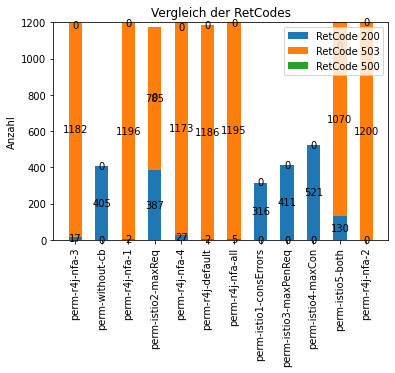

In [31]:
### Insert dataframe for diagramm here
diagramm_df = perm_overload_df
diagramm_df['Labels'] = diagramm_df['Labels'].replace({'overload-':'','-with-config-traefik-cb':'traefik','-with-r4j-cb-':'r4j','-without-cb-':'none','with-default-traefik-':'df-traefik'},regex=True)
###


N = diagramm_df.shape[0]

ind = np.arange(N)   # the x locations for the groups
width = 0.5      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()


p1 = ax.bar(ind, list(diagramm_df['RetCodes.200']), width, label='RetCode 200')
p2 = ax.bar(ind, list(diagramm_df['RetCodes.503']), width, list(diagramm_df['RetCodes.200']), label='RetCode 503')
p3 = ax.bar(ind, list(diagramm_df['RetCodes.500']), width, list(diagramm_df['RetCodes.503']), label='RetCode 500')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Anzahl')
ax.set_title('Vergleich der RetCodes')
ax.set_xticks(ind, labels=list(diagramm_df['Labels']),rotation=90)
ax.legend()

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p3, label_type='center')

plt.show()

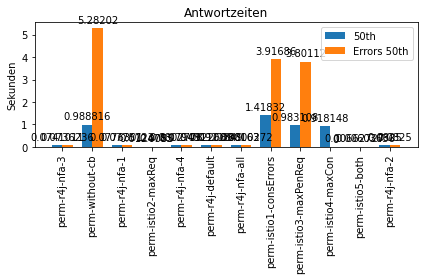

In [32]:

#see: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
labels = diagramm_df['Labels']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list(diagramm_df['50Percentile']), width, label='50th')
rects2 = ax.bar(x + width/2, list(diagramm_df['Errors50Percentile']), width, label='Errors 50th')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sekunden')
ax.set_title('Antwortzeiten')
ax.set_xticks(x, labels, rotation=90)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()